# Task 2: Sentiment Analysis Using Neural Networks

Alex Rivera ID#011243153

Western Governors University

D213 - Advanced Data Analytics

January 09, 2024

## A1: Research Question

The research question for this project is, "Can implementing a neural network for sentiment analysis significantly
predict customer sentiment?"

## A2: Objectives Or Goals

The main objective of the project is to implement a sentiment analysis utilizing neural networks. The goal of the sentiment analysis is to significantly predict customer sentiment with a classification accuracy of 80%. Identifying patterns from customer reviews will lead to a better understanding of the customers and recommendations. 

## A3: Prescribed Network

Recurrent neural networks are a type of neural network that is widely used for natural language processing and classification tasks. The Analytics Vidhya article highlighted that there are multiple types of neural networks that could lead to implementing the wrong neural network that does not match the expectations. Opposed to other neural networks Talaviya stated:

    Recurrent neural networks process sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop (Talaviya, 2023).

The difference in the internal loop allows the RNN to capture the context of the sequences that are being processed. 

## B1: Data Exploration

In [1]:
#Importing necessary packages for the Time Series project 
import pandas as pd 
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
Amazon = pd.read_csv('C:/Users/alexa/WGU/D213/Project/sentiment labelled sentences/amazon_cells_labelled.txt',
                     sep='\t', header=None, names=['Reviews','Sentiment'])

In [3]:
Amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
Amazon

,Reviews,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


### Presence of unusual characters

One of the first data exploration tasks implemented was checking for the presence of unusual characters. Checking the presence of any usual characters is beneficial ahead of tokenization. The review's characters were iterated over and appended to a list for review. The output of the characters are printed below. 

In [5]:
#Webniar referenced for unusual character code(Elleh, 2022)
list_of_characters = []
for review in Amazon['Reviews']:
    for character in review:
        if character not in list_of_characters:
            list_of_characters.append(character)
print(list_of_characters)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']']


### Vocabulary size

The tokenizer class was implemented on the Reviews column of the dataset. The unique and tokenized vocabulary size was found to be 1,879. 

In [6]:
#Webniar referenced for vocabulary size code(Elleh, 2022)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Amazon['Reviews'])
print("Vocabulary size: ", len(tokenizer.word_index) + 1)

Vocabulary size:  1879


### Proposed word embedding length

Data exploration was continued with an effort to propose an embedding length by the following steps. All reviews were combined into a single variable to tokenize. A few calculations were run on the tokenized joined reviews, total length, and average length. The average length plus 1 was the proposed embedding length of 7. 

In [7]:
text = ' '.join(Amazon['Reviews'])

embedding = tf.keras.preprocessing.text.Tokenizer()
embedding.fit_on_texts(Amazon['Reviews'])

total_length = sum(len(word) for word in embedding.word_index.keys())
average_length = total_length / len(embedding.word_index.keys())

embedding_length = int(average_length) + 1

print(f"Embedding length: {embedding_length}")

Embedding length: 7


### Statistical justification for the chosen maximum sequence length

To find the maximum sequence length a for loop was iterated on all the reviews. The max length of the sequence was calculated by appending the length of the reviews split by a space and finding the max of the list. The max length of the sequence was 30.

In [8]:
#Webniar referenced for vocabulary size code(Elleh, 2022)
review_lenght = []
for char_len in Amazon['Reviews']:
    review_lenght.append(len(char_len.split(" ")))
    
review_max = np.max(review_lenght)

print("Max length of sequence is: ",review_max)

Max length of sequence is:  30


## B2: Tokenization

The goal of tokenization according to the TensorFlow natural language processing tutorial, "represent words in a way that a computer can process them, with a view to later training a neural network that can understand their meaning"(Natural Language Processing - Tokenization (NLP Zero to Hero - Part 1), 2020). The process started with normalizing the reviews ahead of tokenization by converting them to lowercase, replacing all dashes with spaces, and removing unusual characters not found in a-zA-Z0-9. Next, the normalized reviews were verified if processed correctly. The next steps in normalizing the reviews were to create functions for lemmatization, "grouping different inflected words together" (Gillis, 2023), and removing stop words(removing words with very little useful information). The final normalized tokenized reviews had the following stats:

- Vocabulary size:  1669
- Embedding length: 7
- Max length of sequence is:  17

In [9]:
#Webniar referenced for removing characters code(Elleh, 2022)
unusual_chars = re.compile(r"[^a-zA-Z0-9\s]+")

reviews_cleaned = []

for review in Amazon['Reviews']:
    cleaned_review = review.lower()
    cleaned_review = cleaned_review.replace("-", " ")
    cleaned_review = unusual_chars.sub('', cleaned_review)
    reviews_cleaned.append(cleaned_review)

Amazon['Reviews'] = reviews_cleaned

In [10]:
#Webniar referenced for unusual character code(Elleh, 2022)
list_of_characters = []
for review in Amazon['Reviews']:
    for character in review:
        if character not in list_of_characters:
            list_of_characters.append(character)
print(list_of_characters)

['s', 'o', ' ', 't', 'h', 'e', 'r', 'i', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'b', 'c', 'v', 'd', 'x', 'j', '4', '5', 'z', 'q', 'k', '7', '3', '6', '8', '0', '2', '1', '9']


In [11]:
Amazon

,Reviews,Sentiment
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
995,the screen does get smudged easily because it ...,0
996,what a piece of junk i lose more calls on this...,0
997,item does not match picture,0
998,the only thing that disappoint me is the infra...,0


In [12]:
#stop words for filtering
stop_words = stopwords.words('english')

processed_reviews = Amazon['Reviews']
       
#define our lemmatization and stop word removal functions
def lemmatized(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

def remove_stop_words(corpus):
    removed_stop_words = []
    for sentence in corpus:
        removed_stop_words.append(
            ' '.join([word for word in sentence.split() if word not in stop_words])
        )
    return removed_stop_words

In [13]:
#Execute the functions
processed_reviews = lemmatized(processed_reviews)
processed_reviews = remove_stop_words(processed_reviews)

#Print an output of the processed reviews
print(processed_reviews[1])

good case excellent value


In [14]:
#Vocab size code
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_reviews)

#Embedding_length code
text = ' '.join(processed_reviews)
embedding = tf.keras.preprocessing.text.Tokenizer()
embedding.fit_on_texts(processed_reviews)
total_length = sum(len(word) for word in embedding.word_index.keys())
average_length = total_length / len(embedding.word_index.keys())
embedding_length = int(average_length) + 1
#Max lenght code
review_lenght = []
for char_len in processed_reviews:
    review_lenght.append(len(char_len.split(" ")))    
review_max = np.max(review_lenght)


print("Vocabulary size: ", len(tokenizer.word_index) + 1)
print(f"Embedding length: {embedding_length}")
print("Max length of sequence is: ",review_max)

Vocabulary size:  1669
Embedding length: 7
Max length of sequence is:  17


In [15]:
#Tokenize the reviews
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(processed_reviews)

## B3: Padding Process

Once the normalization and data preparation are complete the padding process can be implemented on the processed reviews. First texts_to_sequences() function is run on all the processed reviews to create sequences to be inputted into the pad_sequences() function. The padding occurs after the text sequence by selecting padding='post'. An output of a single padded sequence is printed below.

In [16]:
#Article refernced for padding code(Training a model to recognize sentiment in text (NLP Zero to Hero - Part 3), 2020)
sequences = tokenizer.texts_to_sequences(processed_reviews)
padded = sequence.pad_sequences(sequences, padding='post')
vocab_size = len(tokenizer.word_index) + 1
print(padded[1])

[  5  15  23 193   0   0   0   0   0   0   0   0   0   0   0   0   0]


## B4: Categories Of Sentiment

The data provided has two sentiment values 0 for negative and 1 for positive. Throughout the analysis, the two categories were kept. The final dense layer of the neural network will utilize a sigmoid activation function, according to Saeed, "A sigmoid function is a guarantee that the output of this unit will always be between 0 and 1" (Saeed, 2021). This final dense layer activation function will help in the classification of sentiment analysis.

## B5: Steps To Prepare The Data

- Import necessary packages for sentiment analysis: Pandas, Numpy, Re, Tensorflow, Nltk, Sklearn, Keras, and Matplotlib
- Import and perform data exploration:
    - Presence of unusual characters
    - Vocabulary size
    - Proposed word embedding length
    - Statistical justification for the chosen maximum sequence length
- Normalize review data sentences ahead of tokenization
    - Converted sequences to lowercase
    - Replaced all dashes with spaces
    - Removed unusual characters not found in a-zA-Z0-9
    - Lemmatization of sequences
    - Removed stop words
- Tokenize the normalized processed sequences
- Apply post-padding processes to the processed sequences
- Reshape the padded sequences to process into training, test, and validation splits
- Split data into 80% training data, 10% test, and 10% validation.
     - An 80/20 split was utilized with the 20 percent further split evenly into test and validation.

In [17]:
#Reshaping padded reviews 
padded_array = padded.reshape(1000, 17, 1)

review_list = []

#Run loop on padded reviews
for review in padded_array:
    review_list.append(review)

Amazon['Reviews'] = review_list 

X = Amazon['Reviews']
y = Amazon['Sentiment']

# Splitting data into training 80% and test 20%
X_train, X_V, y_train, y_V = train_test_split(X, y, train_size=.8, random_state=1)
#Further splitting the 20% into 10% validation and 10% testing 
X_valid, X_test, y_valid, y_test = train_test_split(X_V, y_V, train_size=.5, random_state=1)

In [18]:
#Reshaping the split for use in the tenserflow model
X_train = np.array(X_train.values.tolist()).reshape(X_train.shape[0], 17, 1)
y_train = np.array(y_train.values.tolist()).reshape(y_train.shape[0], 1)
X_valid = np.array(X_valid.values.tolist()).reshape(X_valid.shape[0], 17, 1)
y_valid = np.array(y_valid.values.tolist()).reshape(y_valid.shape[0], 1)
X_test = np.array(X_test.values.tolist()).reshape(X_test.shape[0], 17, 1)
y_test = np.array(y_test.values.tolist()).reshape(y_test.shape[0], 1)

## B6: Prepared Data Set

In [19]:
#Save prepared Sentiment Analysis dataset to CSV 
Amazon.to_csv('C:/Users/alexa/WGU/D213/Project/Sentiment_Analysis_Prepared.csv', index=False)

## C1: Model Summary

In [20]:
#Article refernced for RNN code (Text classification with an RNN : tensorflow, 2023)
model_sequential = Sequential()
embedding_layer = Embedding(input_dim=vocab_size, output_dim=200, input_length=17)
model_sequential.add(embedding_layer)

model_sequential.add(Bidirectional(LSTM(50)))
model_sequential.add(Dense(25))
model_sequential.add(Dense(1, activation='sigmoid'))

In [21]:
#Webniar referenced for model summary code(Elleh, 2022)
model_sequential.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model_sequential.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 200)           333800    
                                                                 
 bidirectional (Bidirection  (None, 100)               100400    
 al)                                                             
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 436751 (1.67 MB)
Trainable params: 436751 (1.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## C2: Network Architecture

The network architecture is implemented as a recurrent neural network. Tensorflow published a tutorial on implementing a neural network for text classification, and a similar RNN architecture was implemented(Text classification with an RNN: TensorFlow, 2023). The four layers were made up of 1st embedding, 2nd bidirectional(hidden), 3rd Dense(hidden), and 4th Dense(output). Additional stats of the layers are below:

- 1st Layer: Core type = Embedding

    - Layer type = Input
    - Number of Parameters = 333,800
     
- 2nd Layer: Core type = Bidirectional

    - Layer type = Hidden
    - Number of Parameters = 100,400

- 3rd Layer: Core type = Dense

    - Layer type = Hidden
    - Number of Parameters = 2,525
    
- 4th Layer: Core type = Dense

    - Layer type = Output
    - Number of Parameters = 26

## C3: Hyperparameters

### Activation functions

The activation function implemented on the final layer was sigmoid, this function works particularly well for binary classification. The inputs of the function are turned into outputs ranging from 0-1 and are referred to as a "squashing function" (Buhl, 2023). 

### Number of nodes per layer

The number of nodes per layer was chosen by experimentation and following a few tutorials on neural network sentiment analysis. In Dr. Elleh's and Tenserflow's examples, all nodes started with an input layer of 100-200 and were reduced by half in the hidden layer to finish with a single layer for classification (Text classification with an RNN: TensorFlow, 2023). The following node counts were finalized due to the accuracy: 1st layer 200 nodes, 2nd layer 100 nodes, 3rd layer 50 nodes, and 4th layer 1 node.

###  Loss function

Dr. Elleh's webinar highlighted three loss function parameters to review. The loss function selected was binary_crossentropy due to it's performance in classification analysis(Elleh, 2022). All other loss functions were either multi-class or worked on integers which would not fit the analysis. 

### Optimizer

Choosing Adam as an optimizer was quick after some research. Brownlee highlighted the optimizer is straightforward and efficient to implement and, "Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods" (Brownlee, 2021). 

###  Stopping criteria

The stopping criteria parameter implemented was early stopping with a patience of two. This will allow the model to monitor if the validation score does not improve for two epochs and avoid overfitting by stopping. Code for EarlyStopping below:

In [22]:
#Webniar referenced for early stopping code(Elleh, 2022)
early_stopping_monitor = EarlyStopping(patience=2)

### Evaluation metric

The evaluation metric chosen for the analysis is accuracy. It's a simple and effective metric that could be applied to the training and validation/test sets. Dr. Elleh's classification accuracry definition is,"the ratio of the number of correct predictions to the total number of input samples" (Elleh, 2022). 

## D1: Stopping Criteria

The model is fit on the training and validation dataset splits with 25 epochs as a parameter. If no stopping criteria were implemented the model will continue to train through the 25 epochs regardless of the validation accuracy dropping or not increasing. The stopping criteria of EarlyStopping(patience=2) was implemented, so the model would stop training if there was no improvement after two epochs. The impact of the patience of two is that the model trained to 5 out of 25 epochs due to no improvement from the fourth epoch valuation accuracy of 0.82 and the fifth valuation accuracy of 0.82.

In [23]:
#Webniar referenced for fitting code(Elleh, 2022)
results = model_sequential.fit(X_train, y_train,
                    validation_data= (X_valid, y_valid),
                    epochs=25, callbacks=early_stopping_monitor)

Epoch 1/25


25/25 [==============================] - 3s 34ms/step - loss: 0.6860 - acc: 0.5525 - val_loss: 0.6692 - val_acc: 0.7500
Epoch 2/25
25/25 [==============================] - 0s 7ms/step - loss: 0.5410 - acc: 0.8712 - val_loss: 0.4825 - val_acc: 0.7900
Epoch 3/25
25/25 [==============================] - 0s 7ms/step - loss: 0.2176 - acc: 0.9237 - val_loss: 0.4105 - val_acc: 0.8000
Epoch 4/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0851 - acc: 0.9737 - val_loss: 0.4701 - val_acc: 0.8200
Epoch 5/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0404 - acc: 0.9887 - val_loss: 0.6004 - val_acc: 0.8200


## D2: Fitness

The final model's fitness was trained to 4 epochs due to the early stopping patience discussed in section D1. The accuracy of the training data was 0.973 and the validation data was 0.82. To prevent overfitting the following measures were taken to prevent it: the architecture of the neural network and stopping criteria. The architecture followed was a guideline for text classification by Tensorflow, the number of layers and nodes were tweaked for the needs of analysis(Text classification with an RNN: TensorFlow, 2023). Through experimentation, the nodes of the layers were adjusted while reviewing the loss and accuracy of the final model. The ratio of nodes from the first to the last layer was kept roughly aligned throughout the experimentation. The stopping criteria had the biggest impact on addressing overfitting in the final model. Without the patience of 2 implemented the model would have continued to run for 21 more epochs. The model could be improved further with a better understanding of the hyperparameters that make up a good RNN for sentiment analysis or with a large sample size to train and validate. 

## D3: Training Process

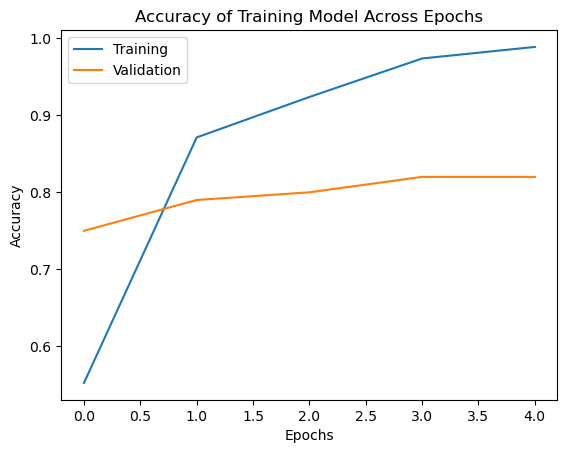

In [24]:
plt.plot(results.history['acc'], label= "Training")
plt.plot(results.history['val_acc'], label= "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy of Training Model Across Epochs")
plt.show()

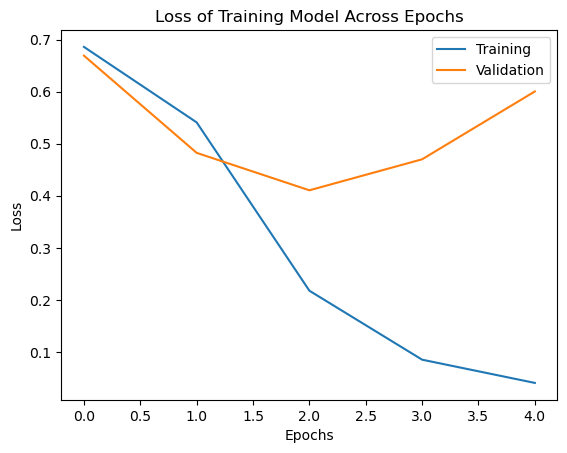

In [25]:
plt.plot(results.history['loss'], label= "Training")
plt.plot(results.history['val_loss'], label= "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss of Training Model Across Epochs")
plt.show()

In [26]:
#Webniar referenced for score code(Elleh, 2022)
score = model_sequential.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.9965 - acc: 0.7600


## D4: Predictive Accuracy

The evaluation metric chosen for the final model was accurate. The final model was fitted with the test data and had a predictive accuracy of 0.76 and a loss of 0.997. To assist in visualizing the predictions a confusion matrix was created below. 

In [27]:
y_pred = model_sequential.predict(X_test)

4/4 [==============================] - 1s 3ms/step


In [28]:
y_pred = np.rint(y_pred)
Matrix = confusion_matrix(y_test, y_pred)
print(Matrix)

[[42 17]
 [ 7 34]]


## E: Code

In [29]:
#Save the model h5 file for submission
model_sequential.save("C:/Users/alexa/WGU/D213/Project/Sentiment_Analysis_Model.h5")

C:\Users\alexa\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## F: Functionality

The initial dataset had 1,000 Amazon reviews, the final model was trained on 800, tested, and validated on 100 reviews each. The neural network architecture was kept simple and the focus of implementing it for NLP analysis. TensorFlow provided guidelines to apply the effective four layers implemented. The hyperparameters continued to focus on classification by implementing a loss function of binary_crossentropy and a final layer including a sigmoid activation function. All these efforts led to a model that was able to predict customer sentiment due to its binary nature. 

## G: Recommendations

The final model can predict customer sentiment at an accuracy of 76% just short of 4% of the goal of 80%. While the model did fall short of the goal, the model does provide predicted value in its current state. The recommendation is to continue hyper-tuning the neural network model to provide parameters to lead to higher accuracy while avoiding overfitting. The RNN architecture is simple with minimal layers that reaching the 80% goal could be as easy as reviewing nodes or activation functions. 

## H: Reporting

Included alongside the executed Jupyter ipynb notebook is a PDF report. 

## I: Sources For Third-Party Code
 
Elleh, F. (2023, November). Advanced Data Analytics - Task 2. https://my.wgu.edu/. Retrieved December 27, 2023, from https://srm.file.force.com/servlet/servlet.FileDownload?retURL=https%3A%2F%2Fsrm--c.vf.force.com%2Fapex%2FFDP%2FCommonsExpandedChatter%3Fcode%3DD213&file=00P3x00001w6g1FEAQ&_CONFIRMATIONTOKEN=VmpFPSxNakF5TXkweE1pMHpNVlF3TlRveU5Eb3dPQzQxT0RCYSxMczlyejZqQkx4RVVFRHhua1dQNldVRWhWWGdtano2WFk1NVVhQVVoWmxNPSxZVEJoTmpobQ%3D%3D&common.udd.actions.ActionsUtilORIG_URI=%2Fservlet%2Fservlet.FileDownload. 

Natural Language Processing - Tokenization (NLP Zero to Hero - Part 1). (2020). YouTube. Retrieved December 27, 2023, from https://youtu.be/fNxaJsNG3-s?si=9RMR-PkeEAAR1we0. 

Text classification with an RNN: tensorflow. TensorFlow. (2023). https://www.tensorflow.org/text/tutorials/text_classification_rnn 

Training a model to recognize sentiment in text (NLP Zero to Hero - Part 3). (2020). YouTube. Retrieved December 27, 2023, from https://youtu.be/Y_hzMnRXjhI?si=ocOmR8Z91UvVqoYR. 

## J: Sources

Brownlee, J. (2021, January 12). Gentle introduction to the adam optimization algorithm for deep learning. MachineLearningMastery.com. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ 

Buhl, N. (2023, July 25). Activation functions in neural networks: With 15 examples. Encord. https://encord.com/blog/activation-functions-neural-networks/ 

Elleh, F. (2023, November). Advanced Data Analytics - Task 2. https://my.wgu.edu/. Retrieved December 27, 2023, from https://srm.file.force.com/servlet/servlet.FileDownload?retURL=https%3A%2F%2Fsrm--c.vf.force.com%2Fapex%2FFDP%2FCommonsExpandedChatter%3Fcode%3DD213&file=00P3x00001w6g1FEAQ&_CONFIRMATIONTOKEN=VmpFPSxNakF5TXkweE1pMHpNVlF3TlRveU5Eb3dPQzQxT0RCYSxMczlyejZqQkx4RVVFRHhua1dQNldVRWhWWGdtano2WFk1NVVhQVVoWmxNPSxZVEJoTmpobQ%3D%3D&common.udd.actions.ActionsUtilORIG_URI=%2Fservlet%2Fservlet.FileDownload. 

Gillis, A. S. (2023, March 13). What is lemmatization?: Definition from TechTarget. Enterprise AI. https://www.techtarget.com/searchenterpriseai/definition/lemmatization 

Saeed, M. (2021, August 17). A gentle introduction to sigmoid function. MachineLearningMastery.com. https://machinelearningmastery.com/a-gentle-introduction-to-sigmoid-function/ 

Talaviya, A. (2023, December 12). Understanding word embeddings and building your first RNN model. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/09/understanding-word-embeddings-and-building-your-first-rnn-model/ 
